In [1]:
import pandas as pd
import numpy as np
from keras.layers import Input, Embedding, Dense, CuDNNLSTM, Dropout, Dense, Bidirectional, BatchNormalization, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from attention import Attention
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_recall_fscore_support, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import keras.backend as K
import tensorflow as tf
import pickle
import re
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
train_dataset = pd.read_csv("../data/clean/train_dataset.csv", index_col = 0)
train_dataset.columns = ["review", "sentiment"]
test_dataset = pd.read_csv("../data/clean/test_dataset.csv", index_col = 0)
test_dataset.columns = ["review", "sentiment"]

In [3]:
label_encoder = LabelEncoder()
train_dataset["sentiment"] = label_encoder.fit_transform(train_dataset["sentiment"])
test_dataset["sentiment"] = label_encoder.fit_transform(test_dataset["sentiment"])

In [4]:
#Create word2idx
def get_word_index(texts):
    word_set = set([j for i in texts for j in i.split()])
    w2i = {v:k+2for k,v in enumerate(word_set)}
    w2i["<PAD>"] = 0
    w2i["<UNK>"] = 1
    i2w = {v:k for k,v in w2i.items()}
    return w2i,i2w

In [5]:
MAX_SEQ = 100
EMBEDDING_SIZE = 300
HIDDEN_LAYER = 128

We will use the f1 score, because the label distribution is imbalance

In [6]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
def print_metrics(y_true, y_pred):
    print("AUC Score: %.2f" %roc_auc_score(y_true, y_pred))
    print("F1 Score: %.2f" %f1_score(y_true, y_pred, average='macro'))
    print("ACCURACY Score: %.2f" %accuracy_score(y_true, y_pred))

**Archi: using 2 BiCuDNNLSTM/LSTM -> Attention -> Dense -> Dense. Using Attention, because the input text is mostly a relatively long text (around 50 words each text)**

In [8]:
def create_model(w2i, max_seq, embedding_size, hidden_layer):
    i = Input(shape = (max_seq,))
    o = Embedding(input_dim=len(w2i),
                  output_dim=embedding_size)(i)
    o = SpatialDropout1D(0.1)(o)
    o = Bidirectional(CuDNNLSTM(hidden_layer, return_sequences = True))(o) 
    o = Bidirectional(CuDNNLSTM(hidden_layer//2, return_sequences = True))(o) 
    o = SpatialDropout1D(0.3)(o)
    o = Attention(MAX_SEQ)(o)
    o = Dropout(0.1)(o)
    o = BatchNormalization()(o)
    o = Dense(hidden_layer, activation='relu')(o)
    o = Dropout(0.3)(o)
    o = BatchNormalization()(o)
    o = Dense(1, activation='sigmoid')(o)

    model = Model(inputs = i, outputs = o)
    
    return model

In [12]:
def save_model(counter, saved_model, w2i, i2w):
    counter = str(counter)
    model_path = "../model/model_"+counter+"/ensemble_model_"+counter+".h5"
    w2i_path = "../model/model_"+counter+"/w2i_model_"+counter+".pkl"
    i2w_path = "../model/model_"+counter+"/i2w_model_"+counter+".pkl"
    saved_model.save_weights(model_path)
    pickle.dump(w2i,open(w2i_path, "wb"))
    pickle.dump(i2w, open(i2w_path, "wb"))

In [13]:
best_auc = 0
count = 0
skf = StratifiedKFold(n_splits = 10)
pred_cv = np.zeros(len(train_dataset))
pred_test = np.zeros(len(test_dataset))

In [14]:
for train_index, val_index in skf.split(train_dataset, train_dataset["sentiment"].values):
    print("Iteration ke-", count)
    train_set, val_set = train_dataset.iloc[train_index,:], train_dataset.iloc[val_index,:]
    train_set = train_set.reset_index(drop = True)
    val_set = val_set.reset_index(drop = True)
    
    train_text = train_set["review"]
    val_text = val_set["review"]
    test_text = test_dataset["review"].values
   
    y_train, y_val = train_set["sentiment"].values, val_set["sentiment"].values
    y_test = test_dataset["sentiment"]
        
    word_2_index, index_2_word = get_word_index(train_text)
    
    X_train_tokenized = pad_sequences([[word_2_index.get(j,1) for j in i.split()] for i in train_text], maxlen = MAX_SEQ)
    X_val_tokenized = pad_sequences([[word_2_index.get(j,1) for j in i.split()] for i in val_text], maxlen = MAX_SEQ)
    X_test_tokenized = pad_sequences([[word_2_index.get(j,1) for j in i.split()] for i in test_text], maxlen = MAX_SEQ)
    
    model = create_model(w2i=word_2_index, 
                         max_seq=MAX_SEQ,
                         embedding_size=EMBEDDING_SIZE,
                         hidden_layer=HIDDEN_LAYER)
    model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=[f1, 'accuracy'])
    
    e_s = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.01 ,verbose = 1, mode='min', restore_best_weights=True)
    l_r = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, mode='min', verbose=1)
    
    model.fit(X_train_tokenized, 
              y_train, 
              batch_size=32, 
              epochs = 100,
              validation_data=(X_val_tokenized, y_val),
              verbose=1,
              callbacks=[e_s, l_r],
              shuffle = True)
    
    val_pred = model.predict(X_val_tokenized)[:,0]
    test_pred = model.predict(X_test_tokenized)[:,0]
    pred_cv[[val_index]] += val_pred
    pred_test += test_pred
    
    save_model(counter=count, saved_model=model, w2i = word_2_index, i2w=index_2_word)
    val_pred_tmp = [1 if i>0.5 else 0 for i in val_pred]
    print_metrics(y_true=y_val, y_pred = val_pred_tmp)
    count += 1 
    K.clear_session()

Iteration ke- 0
Train on 1602 samples, validate on 178 samples
Epoch 1/100
1602/1602 [==============================] - 6s 4ms/step - loss: 0.7085 - f1: 0.6853 - accuracy: 0.6099 - val_loss: 0.6092 - val_f1: 0.7207 - val_accuracy: 0.7079
Epoch 2/100
1602/1602 [==============================] - 4s 3ms/step - loss: 0.3001 - f1: 0.9126 - accuracy: 0.8826 - val_loss: 0.4540 - val_f1: 0.7190 - val_accuracy: 0.8483
Epoch 3/100
1602/1602 [==============================] - 5s 3ms/step - loss: 0.1192 - f1: 0.9728 - accuracy: 0.9632 - val_loss: 0.3810 - val_f1: 0.7310 - val_accuracy: 0.8596
Epoch 4/100
1602/1602 [==============================] - 5s 3ms/step - loss: 0.0635 - f1: 0.9877 - accuracy: 0.9825 - val_loss: 0.4978 - val_f1: 0.7256 - val_accuracy: 0.8202
Epoch 5/100
1602/1602 [==============================] - 5s 3ms/step - loss: 0.0592 - f1: 0.9680 - accuracy: 0.9825 - val_loss: 0.5252 - val_f1: 0.6386 - val_accuracy: 0.7416
Epoch 6/100
1602/1602 [==============================] - 5s 3m

*We want to look for the best threshold that giving best result in the validation data, then we will use it for the testing data*

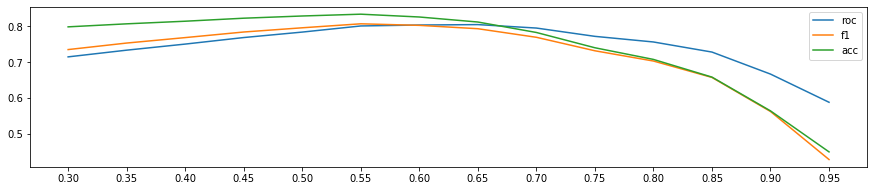

In [15]:
roc_scores = []
f1_scores = []
acc_scores = []
threshold = np.arange(0.3, 1, 0.05)

for th in threshold:
    pred_cv_tmp = np.asarray([1 if i>th else 0 for i in pred_cv])
    roc_score = roc_auc_score(train_dataset["sentiment"], pred_cv_tmp)
    roc_scores.append(roc_score)
    a,b,c,d = precision_recall_fscore_support(train_dataset["sentiment"], pred_cv_tmp, average='macro')
    f1_scores.append(c)
    acc_score = accuracy_score(train_dataset["sentiment"], pred_cv_tmp)
    acc_scores.append(acc_score)
plt.figure(figsize = (15,10))
plt.subplot(3,1,1)
plt.plot(threshold,roc_scores,label= "roc")
plt.plot(threshold,f1_scores,label= "f1")
plt.plot(threshold,acc_scores,label="acc")
plt.xticks(threshold)
plt.legend()

In [18]:
import copy
tmp_pred_cv = [1 if i > 0.55 else 0 for i in pred_cv]
tmp_pred_test = copy.deepcopy(pred_test)
tmp_pred_test /= count
tmp_pred_test = [1 if i > 0.55 else 0 for i in tmp_pred_test]

print("predict on validation data")
print_metrics(train_dataset["sentiment"], tmp_pred_cv)
print("==")
print("predict on test data")
print_metrics(test_dataset["sentiment"], tmp_pred_test)

predict on validation data
AUC Score: 0.80
F1 Score: 0.81
ACCURACY Score: 0.83
==
predict on test data
AUC Score: 0.84
F1 Score: 0.85
ACCURACY Score: 0.86


**better than plain model, and still not overfit**